# Cell Segmentation 🔬 + 🤖 -> 🦠

This document contains three sections:

1. **Image Segmentation Walkthrough with SegFormer 📸**: model usage on their specific domain task and how the dataset interacts with them.
1. **Training + Weights & Biases experiment tracking 🪄 + 🐝**: the training dynamic, hyperparameters, and experiment tracking using Weights & Biases (W&B).
1. **Training script via command line 🚀**: a section to experiment with different model configurations using a training script.



**Relevant links:**

1. Dataset repository: https://huggingface.co/datasets/alkzar90/cell_benchmark
1. W&B project: https://wandb.ai/alcazar90/cell-segmentation
1. SegFormer paper: https://arxiv.org/pdf/2105.15203.pdf

In [1]:
# install additional packages
!pip install -qqq -U datasets transformers wandb 

In [2]:
import os
import random
import math
import wandb
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from datasets import load_dataset

from transformers import (
    SegformerForSemanticSegmentation, 
    SegformerImageProcessor,)

import torch
from torch import nn
from torch import optim

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def set_seed(seed: int = 1337) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

## 1. Image Segmentation Walkthrough with `SegFormer` 📸

### Download & prepare the dataset

Download the dataset from its [Hugging Face repository](https://huggingface.co/datasets/alkzar90/cell_benchmark) and separate it by training, validation, and testing splits.

In [79]:
repo_name = "alkzar90/cell_benchmark"
train_ds = load_dataset(repo_name, split="train", streaming=False)
val_ds = load_dataset(repo_name, split="validation", streaming=False) 
test_ds = load_dataset(repo_name, split="test", streaming=False) 

Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)
Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)
Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)


Quickly we check the number of images per split.


In [41]:
len(train_ds), len(val_ds), len(test_ds)

(10, 3, 2)

In [80]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3332x2527>,
 'masks': <PIL.PngImagePlugin.PngImageFile image mode=L size=3332x2527>}

What does it look like in an image with their respective mask?

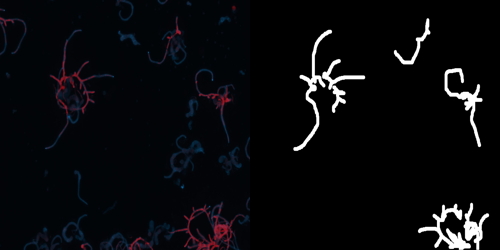

In [42]:
idx=5

one_example=Image.fromarray(
    np.hstack([np.array(train_ds[idx]["image"].resize((250, 250))), 
               # repeat 3 times de color channel -> (height, width, channel)
               np.repeat(np.array(train_ds[idx]["masks"].resize((250, 250))), 3).reshape((250, 250, 3))])
)
one_example

Apply the transformations used by the pre-trained model to the dataset (e.g. 512px resolution).

In [45]:
# Transformations used by the pre-trained model
feature_extractor = SegformerImageProcessor()

# Custom transformation for data augmentation purposes 
jitter = transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['image']]
    labels = [x for x in example_batch['masks']]
    inputs = feature_extractor(images, labels, return_tensors="pt")
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['image']]
    labels = [x for x in example_batch['masks']]
    inputs = feature_extractor(images, labels, return_tensors="pt")
    return inputs

In [46]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

Now, observations have the transformations demanded by the model. Nevertheless, we must create a data collator (i.e. `collate_fn`) to adapt it for PyTorch tensors and pass it to the `DataLoader` constructor.

In [47]:
batch = train_ds[0:2]
batch["pixel_values"].shape, batch["labels"].shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 512, 512]))

Review the [`collate_fn`](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) and [`torch.stack`](https://pytorch.org/docs/stable/generated/torch.stack.html) PyTorch documentation.


In [49]:
def collate_fn(batch):
    x = [example["pixel_values"] for example in batch]
    y = [example["labels"] for example in batch]
    return torch.stack(x, 0, out=None), torch.stack(y, 0, out=None)

Finally, we can create the data loaders. Let's check one batch size to see if anything is in order.

In [50]:
train_dl = DataLoader(train_ds,
                          batch_size=2,
                          shuffle=True,
                          collate_fn=collate_fn)


val_dl = DataLoader(val_ds,
                        batch_size=len(val_ds),
                        shuffle=False,
                        collate_fn=collate_fn)

In [51]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 512, 512]))

Alright 👌! The batch tensor shape match what we expected: `(batch_size, channels (i.e. RGB), height, width)`.

### Download and initialize the pre-trained SegFormer model

We will use a checkpoint from the SegFormer model [`nvidia/mit-b0`](https://huggingface.co/nvidia/mit-b0), which we can download using the transformer module directly from the HuggingFace model repository.

More information about the model architecture and performance in benchmark datasets is in the paper [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers (Xie et al. 2021)](https://arxiv.org/abs/2105.15203).


In [52]:
# we can create store this dictionary in our dataset repository 
# if we are using HF datasets 
id2label = {
    0: 'non-transformed',
    1: 'transformed'
}

label2id = {v: k for k, v in id2label.items()}

pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_

First, let's perform a sanity check to verify if one observation flows through the model correctly.


In [53]:
out = model(train_ds[0]["pixel_values"].unsqueeze(0))
out["logits"].shape

torch.Size([1, 2, 128, 128])

Idem, but using a batch.

In [54]:
model(xb)["logits"].shape

torch.Size([2, 2, 128, 128])

### Upscale model output with `upscale_logits`

Figure 2 from the SegFormer paper shows the model architecture. Notice how each transformer block performs a 1/4 resolution downsampling; every transformer block is connected sequentially with the next one and directly with an MLP layer (pyramid scheme) that upscales into 1/4 the original resolution. Therefore, the output logits from the decoder still are 1/4 of the original input shape, so we need to upscale into the 512px input resolution.

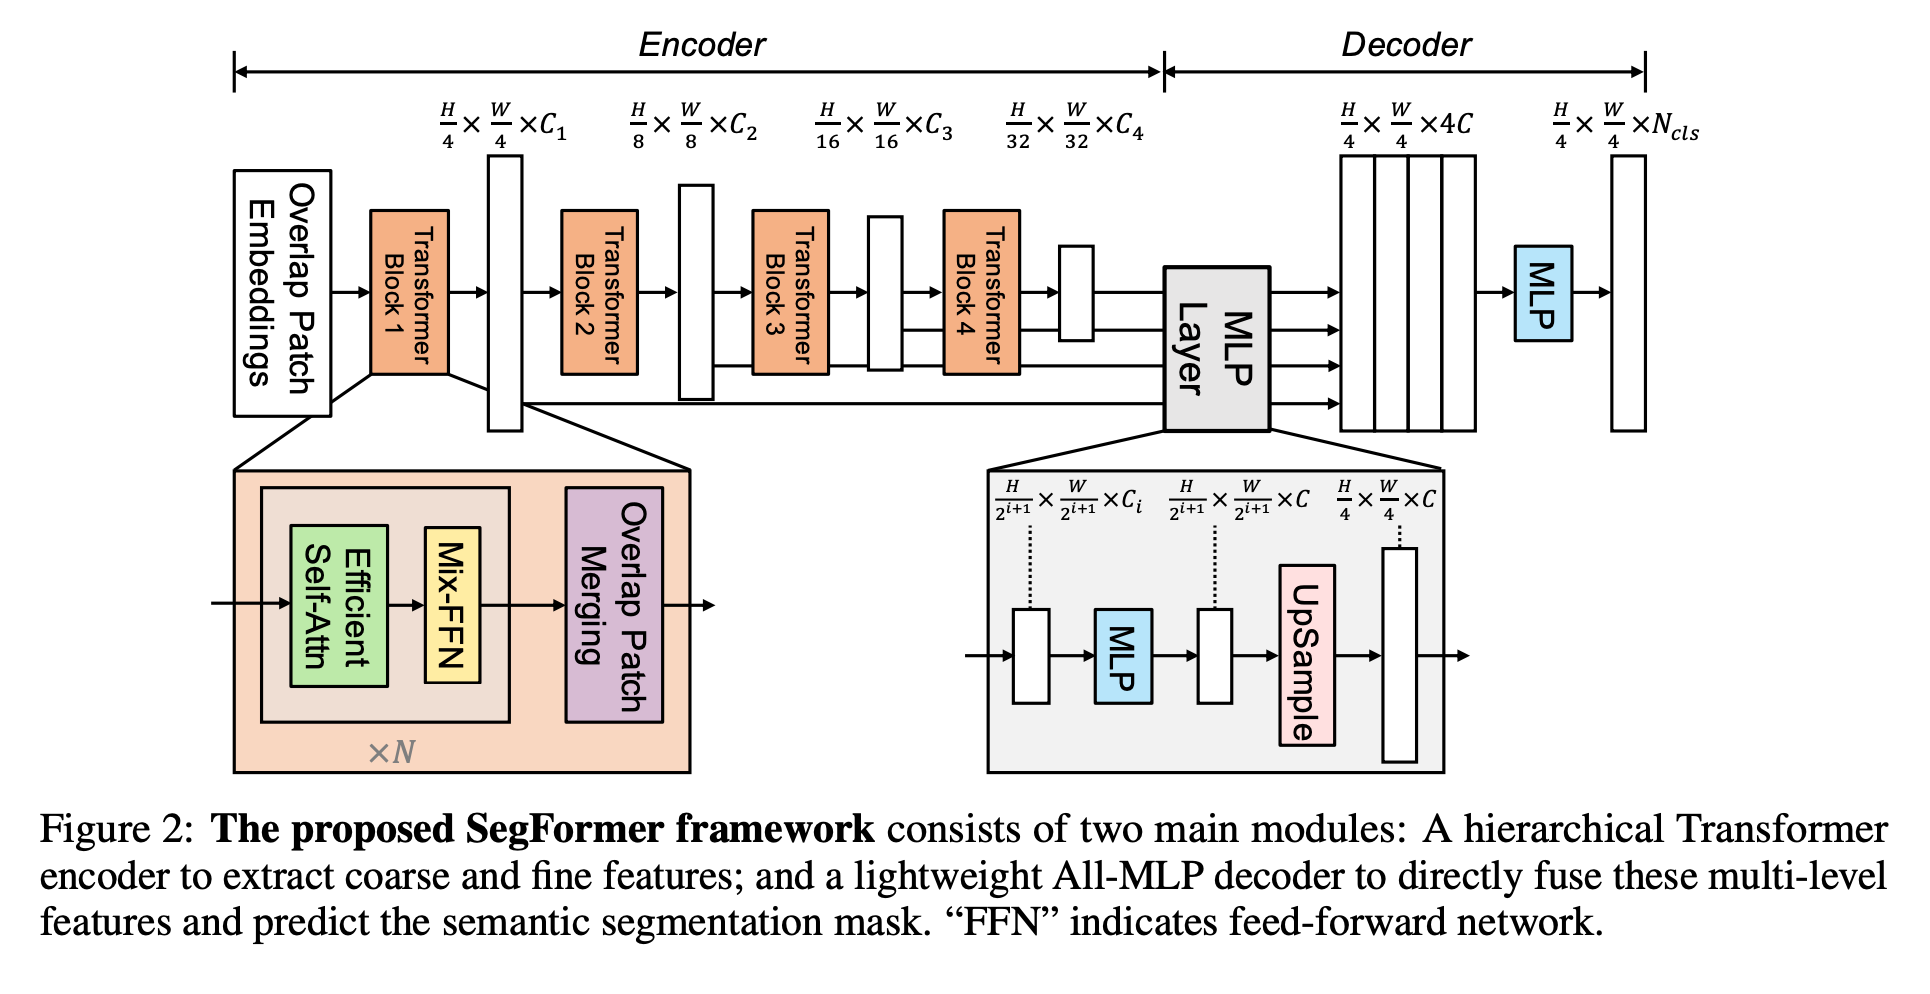

In a nutshell, we need to take the model logits `(128, 128)` and upscale them four times `(128 x 4, 128 x 4)` to get the input shape resolution `(512, 512)`. We will use a bilinear interpolation to upscale the logits to the original shape.

In [55]:
def upscale_logits(logit_outputs, res=512):
    """Upscale logits (4W)x(4H) using bilinear interpolation to recover the original input shape"""
    return nn.functional.interpolate(
      logit_outputs,
      size=(res,res),
      mode='bilinear',
      align_corners=False
    )

Trying with one observation `(one_example, two classes, 128, 128)`:

In [56]:
upscale_logits(out["logits"]).shape

torch.Size([1, 2, 512, 512])

Idem, but using a batch.

In [59]:
upscale_logits(model(xb)["logits"]).shape

torch.Size([2, 2, 512, 512])

### Pixel-wise cross-entropy loss using `nn.BCELoss`

Now that we have the model predictions of the same input shape, we move to compare the predictions with the true masks using nn.BCELoss. The plan is something like the following:

* Adapt the output dimensions to have one label for each pixel, the output `(batch_size, label, height, weights)` must be comparable with the label predictions `(batch_size, height, weights)` using the `torch.max` function.
* Everything will be a 1D flattened tensor.
* `nn.BCELoss` will compare the element-by-element discrepancies and aggregate them into a single scalar number.

In [60]:
# each pixel get one logits per class (2 classes in this case) -> (batch_size, class, height, weight)
upscale_logits(out["logits"]).shape

torch.Size([1, 2, 512, 512])

We will transform logits into a multinomial distribution using the softmax function across dimension 1 (i.e. labels). In this case, we have two classes, so having just one channel, we know the other by `p(b)= 1 - p(a)`. Therefore, we pick the `label=1` (i.e. the signal).

In [61]:
probs = torch.softmax(upscale_logits(model(xb)["logits"]), dim=1)
print(probs.shape)
# pick probs from label 1
probs = probs[:, 1, :, :]
probs.shape

torch.Size([2, 2, 512, 512])


torch.Size([2, 512, 512])

We compact the `probs` tensor into a 1D tensor, keeping the batch dimension (`dim=0`).


In [62]:
preds = probs.contiguous().view(probs.shape[0], -1)
preds.shape

torch.Size([2, 262144])

In [63]:
yb[0,:,:].unique()

tensor([  0,  11,  16,  32,  33,  36,  47,  48,  52,  55,  58,  62,  63,  64,
         73,  75,  79,  80,  83,  95,  96, 105, 110, 111, 112, 113, 115, 126,
        127, 128, 143, 144, 146, 147, 149, 159, 160, 175, 176, 182, 183, 191,
        192, 196, 197, 200, 207, 208, 223, 224, 229, 232, 234, 239, 240, 247,
        255])

and do the same for the target tensor.

In [64]:
target=torch.where(yb > 0.0, 1.0, 0.0).contiguous().view(yb.shape[0], -1)
target.shape

torch.Size([2, 262144])

Finally, the loss is computed by taking both tensors as input.

In [65]:
loss_fn = nn.BCELoss()

loss_fn(
  preds,
  target
)

tensor(0.6914, grad_fn=<BinaryCrossEntropyBackward0>)

The `flatten_logits` is an utility function, a wrapper for the tensor transformations shown before to flatten the logits from the model.

In [66]:
def flatten_logits(logits):
  """Logits output from the SegFormer model with shape: (batch_size * height * width, num_classes)
  Return the logits with shape (batch_size * height * width, num_classes) ready to
  compute pixel-wise cross-entropy loss.
  """
  return logits.contiguous().view(logits.shape[0], -1)


In [ ]:
# sanity check
torch.all(torch.where(yb > 0.0, 1.0, 0.0).contiguous().view(yb.shape[0], -1) == flatten_logits(torch.where(yb > 0.0, 1.0, 0.0)))

tensor(True)

### Intersection over Union metric

**TODO**: see this [blogpost](https://www.jeremyjordan.me/semantic-segmentation/#:~:text=The%20most%20commonly%20used%20loss,one%2Dhot%20encoded%20target%20vector).

In [ ]:
pass

### Overfit a mini-batch with two images

The input images pass correctly through the model, and we show how to compare the predictions obtained from the model output with the actual masks. The loss allows us to backpropagate the gradients to update the parameters in the direction to minimize it. We are ready to perform the next sanity check: overfitting a single mini-batch to inspect how gradients flow and see if the model can memorize the observations.

In [67]:
set_seed()  # for reproducibility

model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)
model=model.to(device)
lr = 1e-4 
n_epochs = 1000
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# move tensors into the current device
xb=xb.to(device)
yb=yb.to(device)

Random seed set as 1337


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_

But first, look at the predicted mask without updating the parameters using our mini-batch.


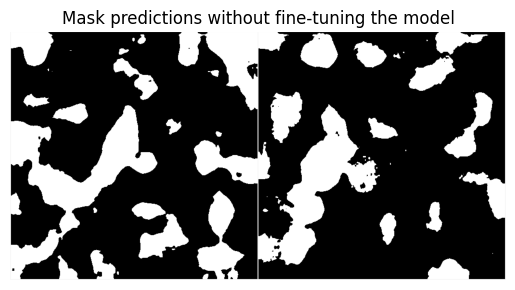

In [68]:
#@title
grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"Mask predictions without fine-tuning the model");

Look at some examples in the [dataset viewer](https://huggingface.co/datasets/alkzar90/cell_benchmark/viewer/default/train); the above-predicted masks could be better. We will perform one thousand steps to update the parameters.

In [69]:
set_seed()  # for reproducibility

# the target will be constant (just one batch)
target=flatten_logits(torch.where(yb > 0.0, 1.0, 0.0))
lossi=np.zeros(n_epochs)

for idx in tqdm(range(n_epochs)):

  # Perform a forward pass
  logits = model(xb)["logits"]

  # Upscale the logit tensor and get the probabilities with the softmax
  probs = torch.softmax(upscale_logits(logits), dim=1)

  # keep it just the probability for the class transform (dim=1) -> binary class
  probs = probs[:, 1, :, :]

  # Transform the. probs tensor into one with shape = (batch_size, 512 x 512)
  preds = flatten_logits(probs)

  # Clean the gradients  
  optimizer.zero_grad()

  # Compute the loss
  loss = loss_fn(preds, target)

  # store the current loss value
  cur_loss = loss.item()
  lossi[idx] = cur_loss

  #print(f"Loss at epoch {idx+1}: {cur_loss:.4f}")

  # Backward prop
  loss.backward()

  # Update the parameters
  optimizer.step()

  if idx%100== 0:
    print(f" -- Loss at epoch {idx}: {cur_loss:.4f}")

Random seed set as 1337


  0%|▍                                                                                                                                                      | 3/1000 [00:00<02:19,  7.14it/s]

 -- Loss at epoch 0: 0.6904


 10%|███████████████▎                                                                                                                                     | 103/1000 [00:07<01:04, 14.00it/s]

 -- Loss at epoch 100: 0.0596


 20%|██████████████████████████████▏                                                                                                                      | 203/1000 [00:15<01:02, 12.76it/s]

 -- Loss at epoch 200: 0.0390


 30%|█████████████████████████████████████████████▏                                                                                                       | 303/1000 [00:23<00:55, 12.51it/s]

 -- Loss at epoch 300: 0.0258


 40%|████████████████████████████████████████████████████████████                                                                                         | 403/1000 [00:31<00:49, 12.02it/s]

 -- Loss at epoch 400: 0.0262


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 503/1000 [00:39<00:41, 12.09it/s]

 -- Loss at epoch 500: 0.0202


 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 603/1000 [00:48<00:32, 12.07it/s]

 -- Loss at epoch 600: 0.0171


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 703/1000 [00:56<00:24, 12.02it/s]

 -- Loss at epoch 700: 0.0149


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 803/1000 [01:04<00:16, 12.07it/s]

 -- Loss at epoch 800: 0.0716


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 903/1000 [01:12<00:08, 12.07it/s]

 -- Loss at epoch 900: 0.0242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.36it/s]


The gradients did their work guiding the parameters to minimize the loss.

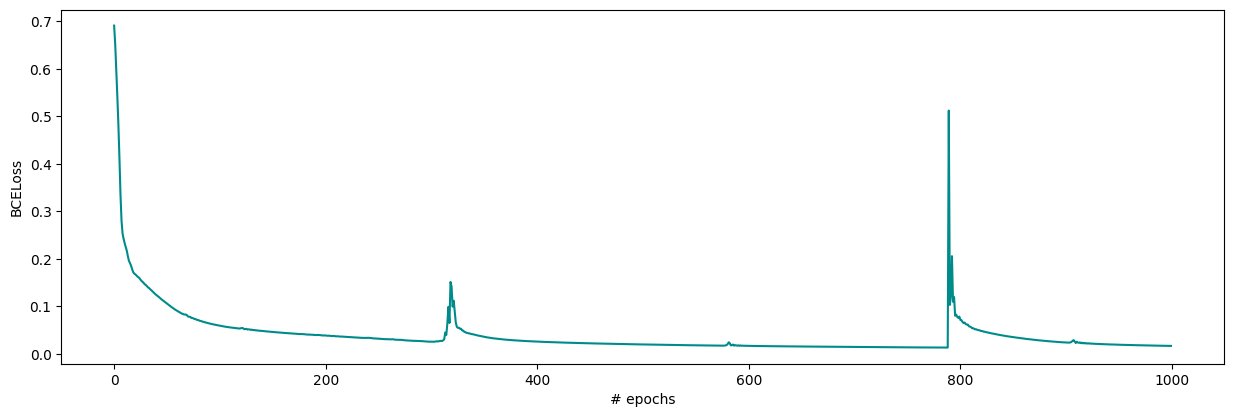

In [70]:
plt.figure(figsize=(15, 4.6));
plt.plot(lossi, color="darkcyan");
plt.xlabel("# epochs");
plt.ylabel("BCELoss");

We inspect the predicted masks after the overfitting.

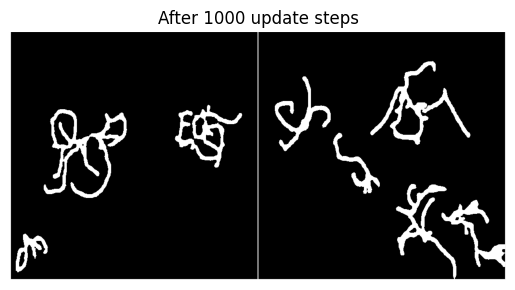

In [71]:
#@title
grid=torchvision.utils.make_grid(
    torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).unsqueeze(1).detach().cpu(),
    nrow=2,
    pad_value=8)

plt.imshow(np.uint8(grid.permute(1,2,0).numpy()) * 255);
plt.axis("off");
plt.title(f"After {n_epochs} update steps");

Below are the authentic masks. As you can observe, the model is exceptionally good at remembering these two examples, which is excellent news. We know that internally, the model deals correctly with our data, and the training dynamics allow it to memorize the observations in their parameters.

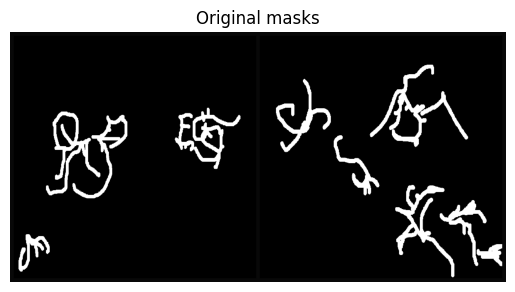

In [72]:
#@title
grid=torchvision.utils.make_grid(
    yb.unsqueeze(1).detach(),
    nrow=2,
    padding=8,
    pad_value=8
    )

plt.imshow(grid.permute(1,2,0).cpu());
plt.axis("off");
plt.title("Original masks");

The quality assessment is ok; now let's compute a metric to quantify the model performance in this test. We will compute the mean intersection over union for the mini-batch.

In [73]:
predicted=torch.argmax(torch.softmax(upscale_logits(model(xb)["logits"]), dim=1), dim=1).detach().cpu()
intersection = torch.logical_and(yb.detach().cpu(), predicted)
union = torch.logical_or(yb.detach().cpu(), predicted)
iou = (torch.div(torch.sum(intersection, dim=(1,2)) + 1e-6, (torch.sum(union, dim=(1,2)) + 1e-6)).sum()/predicted.shape[0]).item()
print(iou)

0.9043543338775635


Almost perfect, but note that we are concentrating the entire model capacity in just two examples. In the next section, we will experiment with different model configurations to achieve a model that performs well in images outside the training set.


## 2. Training + Weights & Biases experiment tracking 🪄 + 🐝

In this section we will start training the model
in the full dataset.

The ultimate goal is to wrapper the training loop into a `.py` file and 
using the `argparse` module for call the script via command line. 



### 💾 Get the data

In [74]:
class CellSegmentation:

  def __init__(self, streaming=False, tfms:dir = None):
    self.repo_name = "alkzar90/cell_benchmark"
    self.train_ds = load_dataset(self.repo_name, split="train", streaming=streaming)
    self.valid_ds = load_dataset(self.repo_name, split="validation", streaming=streaming)
    self.test_ds = load_dataset(self.repo_name, split="test", streaming=streaming)
    if tfms:
      self.train_ds.set_transform(tfms["train"])
      self.valid_ds.set_transform(tfms["valid"])
      self.test_ds.set_transform(tfms["valid"])


  def get_dataloaders(self, bs=2, collate_fn=None, num_workers=2):
    train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True,
                          collate_fn=collate_fn,
                          num_workers=num_workers)
    valid_dl = DataLoader(self.valid_ds, batch_size=len(self.valid_ds), shuffle=True,
                        collate_fn=collate_fn,
                        num_workers=num_workers)
    test_dl = DataLoader(self.test_ds, batch_size=len(self.test_ds), shuffle=True,
                         collate_fn=collate_fn,
                         num_workers=num_workers)
    return train_dl, valid_dl, test_dl


In [75]:
feature_extractor = SegformerImageProcessor()
jitter = transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
  # se pueden agregar transformaciones para data augmentation 
  # adicionales en esta función como jitter()
  images = [jitter(x) for x in example_batch['image']]
  labels = [x for x in example_batch['masks']]
  inputs = feature_extractor(images, labels, return_tensors="pt")
  return inputs

def val_transforms(example_batch):
  images = [x for x in example_batch['image']]
  labels = [x for x in example_batch['masks']]
  inputs = feature_extractor(images, labels, return_tensors="pt")
  return inputs

def collate_fn(batch):
  """HuggingFace devuelve diccionarios, esta función devuelve tensor input, label
  agrupados por el número de ejemplos que tiene el batch dentro del mismo tensor.
  Es decir, (batch_size, input), (batch_size, target)"""
  x = [example["pixel_values"] for example in batch]
  y = [example["labels"] for example in batch]
  return torch.stack(x, 0, out=None), torch.stack(y, 0, out=None)

Download the dataset from the [repository](https://huggingface.co/datasets/alkzar90/cell_benchmark) and apply the above transformations.

In [76]:
tfms={"train": train_transforms, "valid": val_transforms}
datasets=CellSegmentation(streaming=False, tfms=tfms)

Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)
Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)
Found cached dataset cell_benchmark (/home/m_bobrin/.cache/huggingface/datasets/alkzar90___cell_benchmark/default/0.0.0/ad0163cd0fb1e2ca215ee52344a5e0859fc6994047eb1e1ad5a657445c1fbc1e)


### 🔧 Utility Functions

Functions to manipulate the logits.

In [77]:
def upscale_logits(logit_outputs, res=512):
  """Escala los logits a (4W)x(4H) para recobrar dimensiones originales del input"""
  return nn.functional.interpolate(
      logit_outputs,
      size=(res,res),
      mode='bilinear',
      align_corners=False
  )

def flatten_logits(logits):
  return logits.contiguous().view(logits.shape[0], -1)

### 🔍 Model validation

We will create `validate_model` for tracking and logging the following information:

* Train & Validation loss
* Pixel-wise accuracy
* Mean Intersection over Union
* A table with the validation images, masks, predicted masks and probability
heatmap in the last epoch

In [ ]:
#%%capture
def validate_model(model, valid_dl, loss_fn, log_images=False, num_classes=2):
  """Compute performance of the model on the validation dataset and log a wandb.Table"""
  #cmap = plt.get_cmap('viridis')
  model.eval()
  val_loss = 0.
  iou = 0.
  with torch.inference_mode():
    correct = 0

    iou_by_example = torch.zeros(len(valid_dl.dataset)) # tensor with length equals to the number of validation examples
    for i, (images, masks) in enumerate(valid_dl):
      images, masks = images.to(device), masks.to(device)
      masks=flatten_logits(torch.where(masks > 0.0, 1.0, 0.0))

      # Forward pass ➡
      logits = model(images)["logits"]
      probs = torch.softmax(upscale_logits(logits), dim=1)
      _, predicted = torch.max(probs.data, dim=1)
      probs = probs[:, 1, :, :]
      preds = flatten_logits(probs)
      val_loss+= loss_fn(preds, masks).item()*masks.size(0)

      # Compute pixel accuracy and accumulate
      correct += (flatten_logits(predicted) == masks).sum().item()

      # Compute IoU and accumulate
      mask2d=masks.view(masks.shape[0], predicted.shape[1], -1)
      intersection = torch.logical_and(mask2d, predicted)
      union = torch.logical_or(mask2d, predicted)
      iou += (torch.div(torch.sum(intersection, dim=(1,2)) + 1e-6, (torch.sum(union, dim=(1,2)) + 1e-6)).sum()/predicted.shape[0]).item()

      # tensor with IoU for every example (batch_size x 1)
      iou_by_example = intersection.sum(dim=(1,2), keepdim=False) / (union.sum(dim=(1,2), keepdim=False) + 1e-6)

      
      # Log validation predictions and images to the dashboard
      if log_images:
        if i == 0:
          # 🐝 Create a wandb Table to log images, labels and predictions to
          table = wandb.Table(columns=["image", "mask", "pred_mask", "probs", "iou"])
          for img, mask, pred, prob, iou_metric in zip(images.to("cpu"), masks.to("cpu"), predicted.to("cpu"), probs.to("cpu"), iou_by_example.to("cpu")):
            plt.imshow(prob.detach().cpu());
            #plt.imshow(cmap(prob].detach().cpu().numpy())[:,:,:3])
            plt.axis("off");
            plt.tight_layout();
            table.add_data(wandb.Image(img.permute(1,2,0).numpy()), 
                           wandb.Image(mask.view(img.shape[1:]).unsqueeze(2).numpy()),
                           wandb.Image(np.uint8(pred.unsqueeze(2).numpy())*255),
                           #wandb.Image(Image.fromarray((cmap(prob.detach().cpu().numpy())[:,:,:]*255).astype(np.uint8)[:,:,3]))
                           wandb.Image(plt),
                           iou_metric
                           )
    if log_images:
      wandb.log({"val_table/predictions_table":table}, commit=False)

  return (
        val_loss / len(valid_dl.dataset), 
        correct / (len(valid_dl.dataset)*512**2),
        iou / (i+1)
  )

### 🦾 Run experiment



Set W&B project constants.

In [ ]:
PROJECT = 'cell-segmentation'
#DATA_DIR = Path('data/')
ARTIFACT_PATH = 'wandb/cell-segmentation/CellSegmentation:latest'
BS = 4
NUM_WORKERS=mp.cpu_count()

Initialize the dataloaders with the given batch size (i.e. `BS`) from
the `CellSegmentation` dataset instance:

In [ ]:
train_dl, valid_dl, test_dl = datasets.get_dataloaders(bs=BS, 
                                                       collate_fn=collate_fn,
                                                       num_workers=NUM_WORKERS)

**Download the data from W&B Artifacts**.

In [ ]:
#wandb.init(project=PROJECT, job_type='download_dataset')
wandb.init(project=PROJECT)

#artifact = wandb.use_artifact(ARTIFACT_PATH, type='dataset')

#artifact_dir = artifact.download(DATA_DIR)

wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Set hyperparameters**.

In [ ]:
LR = 3e-4
GAMMA=0.9  # scheduler
EPOCHS = 10
SEED=42313988
MODEL_NAME="nvidia/mit-b0"

# Log the final results on the validation set
LOG_IMAGES=True

Download pre-trained model checkpoint.

In [ ]:
id2label = {
    0: 'non-transformed',
    1: 'transformed'
}
label2id = {v:k for k,v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id
)

model=model.to(device)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj

🐝 initialise a wandb run.

In [ ]:
wandb.init(project=PROJECT, config={"epochs": EPOCHS, "batch_size": BS, "lr": LR,
                                    "lr_scheduler_exponential__gamma": GAMMA, 
                                    "seed": SEED})

# Add additional configs to wandb if needed
wandb.config['len_train'] = len(datasets.train_ds)
wandb.config['len_val'] = len(datasets.valid_ds)

In [ ]:
wandb.config

{'epochs': 10, 'batch_size': 4, 'lr': 0.0003, 'lr_scheduler_exponential__gamma': 0.9, 'seed': 42313988, 'len_train': 10, 'len_val': 3}

Training loop:

Random seed set as 42313988


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:08,  8.10s/it]
2it [00:08,  3.47s/it]
3it [00:10,  2.85s/it]
 10%|█         | 1/10 [00:11<01:43, 11.52s/it]

Train Loss: 0.550, Valid Loss: 0.652, Valid Accuracy: 0.91, mIoU: 0.452



0it [00:00, ?it/s]
1it [00:07,  7.48s/it]
2it [00:07,  3.21s/it]
3it [00:10,  3.16s/it]
 20%|██        | 2/10 [00:23<01:34, 11.86s/it]

Train Loss: 0.483, Valid Loss: 0.643, Valid Accuracy: 0.92, mIoU: 0.464



0it [00:00, ?it/s]
1it [00:07,  7.44s/it]
2it [00:07,  3.20s/it]
3it [00:09,  2.70s/it]
 30%|███       | 3/10 [00:34<01:19, 11.42s/it]

Train Loss: 0.407, Valid Loss: 0.611, Valid Accuracy: 0.93, mIoU: 0.418



0it [00:00, ?it/s]
1it [00:08,  8.53s/it]
2it [00:08,  3.64s/it]
3it [00:10,  2.90s/it]
 40%|████      | 4/10 [00:46<01:09, 11.58s/it]

Train Loss: 0.365, Valid Loss: 0.591, Valid Accuracy: 0.93, mIoU: 0.475



0it [00:00, ?it/s]
1it [00:08,  8.71s/it]
2it [00:08,  3.72s/it]
3it [00:10,  2.91s/it]
 50%|█████     | 5/10 [00:58<00:58, 11.73s/it]

Train Loss: 0.311, Valid Loss: 0.575, Valid Accuracy: 0.94, mIoU: 0.508



0it [00:00, ?it/s]
1it [00:06,  6.69s/it]
2it [00:06,  2.88s/it]
3it [00:08,  2.49s/it]
 60%|██████    | 6/10 [01:08<00:44, 11.13s/it]

Train Loss: 0.275, Valid Loss: 0.467, Valid Accuracy: 0.93, mIoU: 0.393



0it [00:00, ?it/s]
1it [00:07,  7.98s/it]
2it [00:08,  3.44s/it]
3it [00:10,  3.01s/it]
 70%|███████   | 7/10 [01:20<00:34, 11.34s/it]

Train Loss: 0.287, Valid Loss: 0.417, Valid Accuracy: 0.92, mIoU: 0.340



0it [00:00, ?it/s]
1it [00:06,  6.79s/it]
2it [00:07,  2.93s/it]
3it [00:09,  2.53s/it]
 80%|████████  | 8/10 [01:30<00:21, 10.95s/it]

Train Loss: 0.213, Valid Loss: 0.361, Valid Accuracy: 0.92, mIoU: 0.269



0it [00:00, ?it/s]
1it [00:06,  6.84s/it]
2it [00:07,  2.95s/it]
3it [00:09,  2.52s/it]
 90%|█████████ | 9/10 [01:40<00:10, 10.69s/it]

Train Loss: 0.260, Valid Loss: 0.360, Valid Accuracy: 0.92, mIoU: 0.315



0it [00:00, ?it/s]
1it [00:06,  6.66s/it]
2it [00:06,  2.88s/it]
3it [00:09,  2.53s/it]
100%|██████████| 10/10 [01:51<00:00, 11.10s/it]

Train Loss: 0.232, Valid Loss: 0.362, Valid Accuracy: 0.93, mIoU: 0.370


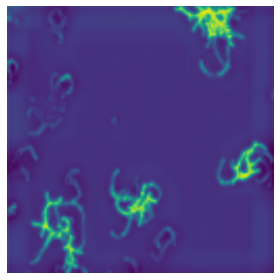

In [ ]:
set_seed(SEED)  # for reproducibility

# Copy your config 
config = wandb.config

# Get the data
n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

# Make the loss, optimizer, and scheduler
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.lr_scheduler_exponential__gamma)

# Training
example_ct = 0
step_ct = 0
max_iou = 0.0
for epoch in tqdm(range(EPOCHS)):
  model.train()
  for step, (images, masks) in tqdm(enumerate(train_dl), leave=False):

    images, masks = images.to(device), masks.to(device)

    # Transforms masks into a 1D tensor with 1.0 and 0.0 (2 classes)
    masks=flatten_logits(torch.where(masks > 0.0, 1.0, 0.0))

    # Perform a forward pass
    logits = model(images)["logits"]

    # Upscale the logit tensor and get the probabilities with the softmax
    probs = torch.softmax(upscale_logits(logits), dim=1)

    # keep it just the probability for the class transform (dim=1) -> binary class
    probs = probs[:, 1, :, :]

    # Transform the. probs tensor into one with shape = (batch_size, 512 x 512)
    preds = flatten_logits(probs)

    # Compute the loss
    train_loss = loss_fn(preds, masks)

    # Clean the gradients  
    optimizer.zero_grad()
    
    # Backward prop
    train_loss.backward()

    # Update the parameters
    optimizer.step()

    example_ct += len(images)
    metrics = {"train/train_loss": train_loss, 
               "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
               "train/example_ct": example_ct,
               "train/cur_learning_rate": scheduler.state_dict()["_last_lr"][0]}
        
    if step + 1 < n_steps_per_epoch:
      # 🐝 Log train metrics to wandb 
      wandb.log(metrics)
            
    step_ct += 1
  
  # Update the learning rate given the scheduler 
  scheduler.step()

  # log validation images and predictions on last epoch
  if LOG_IMAGES:
    log_images = epoch==(config.epochs-1)
  else:
    log_images = False

  # Do validation and maybe log images to Tables
  val_loss, accuracy, mIoU = validate_model(model, valid_dl, loss_fn, log_images=log_images)
  if mIoU > max_iou:
    # Save trained model to disk and to W&B Artifacts
    model_fn = f'{MODEL_NAME.replace("/", "-")}_model.pt'
    torch.save(model, model_fn)
    max_iou = mIoU

  # 🐝 Log train and validation metrics to wandb
  val_metrics = {"val/val_loss": val_loss, 
                 "val/val_accuracy": accuracy,
                 "val/mIoU": mIoU}
  wandb.log({**metrics, **val_metrics})
    
  print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:.3f}, Valid Accuracy: {accuracy:.2f}, mIoU: {mIoU:.3f}")

# Store best model...
#model_fn = f'{MODEL_NAME.replace("/", "-")}_model.pt'
#torch.save(model, model_fn)
wandb.log_artifact(artifact_or_path=model_fn, name=f"nvidia-mit-b0-epoch{epoch+1}", type='model')

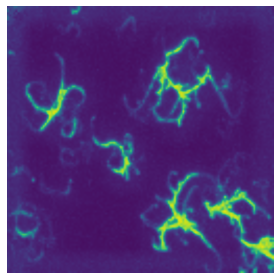

In [ ]:
cmap=plt.get_cmap('viridis')
#Image.fromarray((cmap(probs[0,:,:].detach().cpu().numpy())[:,:,:])[:,:,:])
plt.imshow(cmap(probs[0,:,:].detach().cpu().numpy())[:,:,:3])
plt.axis("off");
#plt.gcf();  
plt.tight_layout();

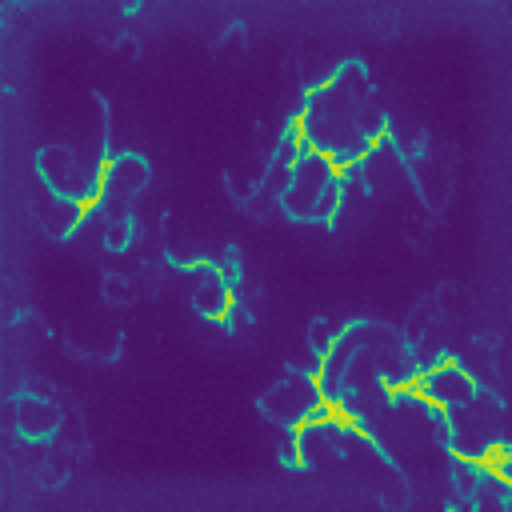

In [ ]:
cmap=plt.get_cmap('viridis')
Image.fromarray((cmap(probs[0,:,:].detach().cpu().numpy())[:,:,:]*255).astype(np.uint8)[:,:,:3])

🐝 Close your wandb run.

In [ ]:
wandb.finish()

train/cur_learning_rate,███▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/train_loss,█▇▇▆▆▅▅▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▁▂▂▂▂▁▁
val/mIoU,▆▇▅▇█▅▃▁▂▄
val/val_accuracy,▁▅▆▇█▆▅▃▄▆
val/val_loss,██▇▇▆▄▂▁▁▁
train/cur_learning_rate,0.00012
train/epoch,10.0
train/example_ct,100
train/train_loss,0.23183


### 🧙 Download model artifact checkpoint from W&B

In [ ]:
  run = wandb.init()
  artifact = run.use_artifact('alcazar90/cell-segmentation/nvidia-mit-b0:v1', type='model')
  artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
model=torch.load('./artifacts/nvidia-mit-b0:v1/nvidia-mit-b0_model.pt')

In [ ]:
model=model.to(device)
model(images)["logits"].shape

torch.Size([2, 2, 128, 128])

## 3. Training script via command line 🚀

Download training script from a github repo:

In [ ]:
!wget https://raw.githubusercontent.com/alcazar90/cell-segmentation/main/finetune_model.py

Usage...

In [ ]:
!python finetune_model.py --train_batch_size 4 --validation_batch_size 3\
     --init_learning_rate 3e-4 --learning_rate_scheduler_gamma 0.92\
     --num_train_epochs 15 --reproducibility_seed 42313988\
     --log_images_in_validation True --dataloader_num_workers 0\
     --model_name "huggingface-segformer-nvidia-mit-b0"\
     --project_name "cell-segmentation"

Random seed set as 42313988
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.p